In [1]:
import torch
import pickle
import numpy as np
from unet import UNet
from modelscope.pipelines import pipeline
from modelscope.utils.constant import ModelFile, Tasks
from typing import Any, Dict
from modelscope.pipelines.base import Input, Pipeline

import utils

import os
import onnxruntime

device = "cpu"
patch_size = 512
input_size = 512

import torchvision.transforms as transforms
image_files_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

import utils
diffuse_mask = utils.gen_diffuse_mask()
diffuse_mask = torch.from_numpy(diffuse_mask).to(device).float()
diffuse_mask = diffuse_mask.permute(2, 0, 1)[None, ...]

def load_onnx_model(onnx_path):
    providers = ['CPUExecutionProvider']
    if torch.cuda.is_available():
        providers.insert(0, 'CUDAExecutionProvider')
    sess = onnxruntime.InferenceSession(onnx_path,providers=providers)
    out_node_name = []
    input_node_name = []
    for node in sess.get_outputs():
        out_node_name.append(node.name)
    for node in sess.get_inputs():
        input_node_name.append(node.name)
    return sess, input_node_name, out_node_name
skin_model_path = "third_party/skin/model.onnx"
sess, input_node_name, out_node_name = load_onnx_model(skin_model_path)

def get_skin(rgb_image):
    rgb_image_small, resize_scale = utils.resize_on_long_side(rgb_image, 800)
    input_feed = {}
    input_feed[input_node_name[0]] = rgb_image_small.astype('float32')
    skin_mask = sess.run(out_node_name, input_feed=input_feed)[0]
    return skin_mask 



bbox_detector_model_id = 'damo/cv_resnet50_face-detection_retinaface'
bbox_detector = pipeline(Tasks.face_detection, model=bbox_detector_model_id, device=device)
bbox_detector.detector.to(device)
print("")

def bbox_detects(rgb_image):
    det_results = bbox_detector(rgb_image)
    results = []
    for i in range(len(det_results['scores'])):
        info_dict = {}
        info_dict['bbox'] = np.array(det_results['boxes'][i]).astype(
            np.int32).tolist()
        info_dict['score'] = det_results['scores'][i]
        info_dict['landmarks'] = np.array(
            det_results['keypoints'][i]).astype(np.int32).reshape(
            5, 2).tolist()
        results.append(info_dict)
    crop_bboxes = utils.get_crop_bbox(results)
    return crop_bboxes


2025-02-03 02:03:14.020277408 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2025-02-03 02:03:14.020331890 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:895 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirementsto ensure all dependencies are met.
2025-02-03 02:03:15,084 - modelscope - WARNING - Model revision not specified, use revision: v2.0.2


2025-02-03 02:03:15,352 - modelscope - INFO - initiate model from /home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface
2025-02-03 02:03:15,353 - modelscope - INFO - initiate model from location /home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface.
2025-02-03 02:03:15,358 - modelscope - WARNING - No preprocessor field found in cfg.
2025-02-03 02:03:15,359 - modelscope - WARNING - No val key and type key found in preprocessor domain of configuration.json file.
2025-02-03 02:03:15,360 - modelscope - WARNING - Cannot find available config to build preprocessor at mode inference, current config: {'model_dir': '/home/dev/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retinaface'}. trying to build by task and model information.
2025-02-03 02:03:15,361 - modelscope - WARNING - Find task: face-detection, model type: None. Insufficient information to build preprocessor, skip building preprocessor
2025-02-03 02:03:15,364 - modelscope - INFO - loa

In [2]:
from modelscope.models.cv.skin_retouching.detection_model.detection_unet_in import \
    DetectionUNet
from modelscope.models.cv.skin_retouching.inpainting_model.inpainting_unet import \
    RetouchingNet

# detect mask
detection_net = DetectionUNet(
    n_channels=3, n_classes=1).to(device)
# local inpainting
inpainting_net = RetouchingNet(
    in_channels=4, out_channels=3).to(device)

det_path = "pretrain_checkpoints/det.pth"
inp_path = "pretrain_checkpoints/inp.pth"

detection_net_ckpt_dict_load = torch.load(det_path, map_location='cpu')
detection_net.load_state_dict(detection_net_ckpt_dict_load['state_dict'])

inp_net_cus_ckpt_dict_load = torch.load(inp_path, map_location='cpu')
inpainting_net.load_state_dict(inp_net_cus_ckpt_dict_load['state_dict'])

detection_net.eval()
inpainting_net.eval()

# retouch network
retouch_generator = UNet(3, 3, deep_supervision=True).to(device)
retouch_path = "pretrain_checkpoints/retouch.pth"
model_state = torch.load(retouch_path, map_location='cpu')
retouch_generator.load_state_dict(
    model_state['state_dict']
)
retouch_generator.eval()
print(f"retouch unet weight path: {retouch_path}")

retouch unet weight path: pretrain_checkpoints/retouch.pth


In [6]:
import torch.nn.functional as F
import numpy as np

def retouch_local_func(image):    
    with torch.no_grad():
        sub_H, sub_W = image.shape[2:]

        sub_image_standard = F.interpolate(
            image, size=(768, 768), mode='bilinear', align_corners=True)
        sub_mask_pred = torch.sigmoid(
            detection_net(sub_image_standard))
        sub_mask_pred = F.interpolate(
            sub_mask_pred, size=(sub_H, sub_W), mode='nearest')

        sub_mask_pred_hard_low = (sub_mask_pred >= 0.35).float()
        sub_mask_pred_hard_high = (sub_mask_pred >= 0.5).float()
        
        sub_mask_pred = sub_mask_pred * (
            1 - sub_mask_pred_hard_high) + sub_mask_pred_hard_high
        sub_mask_pred = sub_mask_pred * sub_mask_pred_hard_low
        sub_mask_pred = 1 - sub_mask_pred

        sub_H_standard = sub_H if sub_H % patch_size == 0 else (
            sub_H // patch_size + 1) * patch_size
        sub_W_standard = sub_W if sub_W % patch_size == 0 else (
            sub_W // patch_size + 1) * patch_size
        
        sub_image_padding = F.pad(
            image,
            pad=(0, sub_W_standard - sub_W, 0, sub_H_standard - sub_H, 0, 0),
            mode='constant',
            value=0)
    
        sub_mask_pred_padding = F.pad(
            sub_mask_pred,
            pad=(0, sub_W_standard - sub_W, 0, sub_H_standard - sub_H, 0, 0),
            mode='constant',
            value=0)

        sub_image_padding = utils.patch_partition_overlap(
            sub_image_padding, p1=patch_size, p2=patch_size)
        sub_mask_pred_padding = utils.patch_partition_overlap(
            sub_mask_pred_padding, p1=patch_size, p2=patch_size)
        B_padding, C_padding, _, _ = sub_image_padding.size()
        
        sub_comp_padding_list = []
        for window_item in range(B_padding):
            sub_image_padding_window = sub_image_padding[
                window_item:window_item + 1]
            sub_mask_pred_padding_window = sub_mask_pred_padding[
                window_item:window_item + 1]

            sub_image_padding_window = (sub_image_padding_window / 2 + 0.5)

            sub_input_image_padding_window = sub_image_padding_window * sub_mask_pred_padding_window
        
            
            sub_output_padding_window = inpainting_net(
                sub_input_image_padding_window,
                sub_mask_pred_padding_window)
            
            sub_comp_padding_window = sub_input_image_padding_window + (
                1
                - sub_mask_pred_padding_window) * sub_output_padding_window

            sub_comp_padding_window = (sub_comp_padding_window - 0.5)*2

            sub_comp_padding_list.append(sub_comp_padding_window)

        sub_comp_padding = torch.cat(sub_comp_padding_list, dim=0)
        sub_comp = utils.patch_aggregation_overlap(
                sub_comp_padding,
                h=int(round(sub_H_standard / patch_size)),
                w=int(round(sub_W_standard
                            / patch_size)))[:, :, :sub_H, :sub_W]

        return sub_comp

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def predict_roi(roi,
                skin_mask_origin,
                degree=1.0,
                smooth_border=False):

    def mg_process(pred_mg, roi, image, skin_mask_origin):
        pred_mg = (pred_mg - 0.5) * degree + 0.5
        pred_mg = pred_mg.clamp(0.0, 1)
        _image = F.interpolate(
            roi, pred_mg.shape[2:], mode='bilinear')
        _image = (_image[0].permute(1, 2, 0) + 1.0) / 2
        
        pred_mg = pred_mg[0].permute(
            1, 2, 0)  # ndarray, (h, w, 1) or (h0, w0, 3)
        
        if len(pred_mg.shape) == 2:
            pred_mg = pred_mg[..., None]

        if smooth_border:
            pred_mg = utils.smooth_border_mg(diffuse_mask, pred_mg)

        skin_mask = skin_mask_origin/255.
        input_region = pred_mg.size()[:2]
        skin_mask = torch.from_numpy(skin_mask).unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).float().to(device)
        skin_mask = F.interpolate(skin_mask, size=input_region, mode='bilinear', align_corners=True)
        skin_mask = skin_mask.permute(0, 2, 3, 1)[0]
        skin_mask_np = (skin_mask*255.).byte().cpu().numpy().astype(np.uint8)
        
        pred_mg = (skin_mask) * pred_mg + (1-skin_mask) * 0.5 * (torch.ones(pred_mg.size()).to(device))
        pred_mg_np = (255. * (pred_mg)).cpu().numpy().astype(np.uint8)
        
        pred = (1 - 2 * pred_mg) * _image * _image \
            + 2 * pred_mg * _image  # value: 0~1
        pred = pred
        pred_numpy = (pred * 255.0).byte().cpu().numpy().astype(np.uint8)

        return pred_mg, pred_mg_np, pred, pred_numpy, skin_mask_np


    with torch.no_grad():
        image = F.interpolate(
            roi, (input_size, input_size), mode='bilinear')

        image_base = (roi[0].permute(1, 2, 0) + 1.0) / 2
        
        pred_mg, pred_mg_x1, pred_mg_x2, pred_mg_x3, pred_mg_x4 = retouch_generator(image)  # value: 0~1
        pred_mg, x0_p2, pred, pred_np, skin_mask = mg_process(pred_mg, roi, image_base, skin_mask_origin)
        # pred_mg_x1, x1_p2, x1_pred, x1_pred_np, skin_mask_x1 = mg_process(pred_mg_x1, roi, image_base, skin_mask_origin)
        # pred_mg_x2, x2_p2, x2_pred, x2_pred_np, skin_mask_x2 = mg_process(pred_mg_x2, roi, image_base, skin_mask_origin)
        # pred_mg_x3, x3_p2, x3_pred, x3_pred_np, skin_mask_x3 = mg_process(pred_mg_x3, roi, image_base, skin_mask_origin)
        # pred_mg_x4, x4_p2, x4_pred, x4_pred_np, skin_mask_x4 = mg_process(pred_mg_x4, roi, image_base, skin_mask_origin)

        # resize back
        pred = pred.permute(2, 0, 1).unsqueeze(0)
        pred = F.interpolate(pred, roi.shape[2:], mode='bilinear')
        pred = pred[0].permute(1, 2, 0)
        pred = (pred * 255.0).byte()
        
        return pred


def img_postprocess(_img, toRGB=True):
    img = _img.clone().permute(0, 2, 3, 1)
    if toRGB == True:
        img = img / 2 + 0.5
    img = img * 255.
    img = img.cpu().numpy().astype(np.uint8)[0]
    h, w= img.shape[:2]
    return cv2.resize(img, (2*w, 2*h))

def tensor2numpy(img):
    return img.cpu().numpy().astype(np.uint8)
    

skin_mask: torch.Size([800, 719])
torch skin_mask: torch.Size([1, 3, 800, 719])
whiten_mg: torch.Size([697, 627, 3]), output_pred: torch.Size([697, 627, 3])


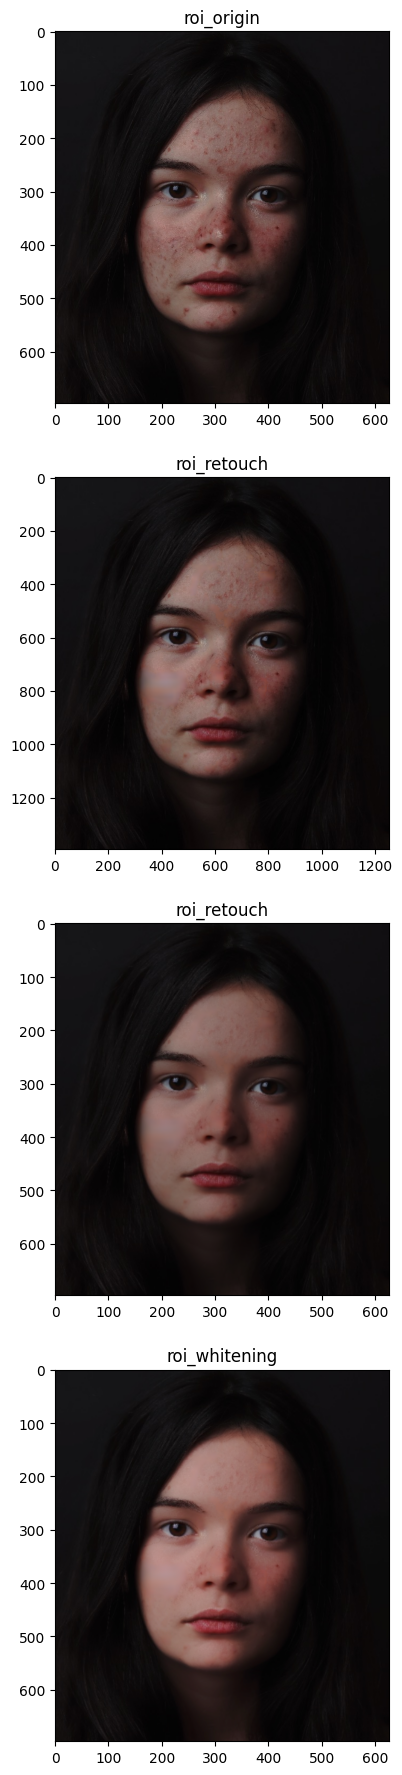

In [8]:
import cv2
import numpy as np
from modelscope.outputs import OutputKeys


def demo(rgb_image):
    retouch_local = True # True
    whitening = True # True
    degree = 0.5 # 1.0
    whitening_degree = 1.2  # 0.8

    plt.figure(figsize=(28, 28))
    
    with torch.no_grad():
        crop_bboxes = bbox_detects(rgb_image)
        
        flag_bigKernal = False
        for bbox in crop_bboxes:
            roi, expand, crop_tblr = utils.get_roi_without_padding(
                rgb_image, bbox)
            roi_skin_mask = get_skin(roi)
            
            plt.subplot(5, 1, 1)
            plt.imshow(roi.copy())
            plt.title('roi_origin')
    
            roi = utils.roi_to_tensor(roi)
            if roi.shape[2] > 0.4 * rgb_image.shape[0]:
                flag_bigKernal = True
            roi = roi.to(device)
            roi = roi / 255.
            roi = utils.preprocess_roi(roi)
            
            if retouch_local and inp_path is not None:
                roi = retouch_local_func(roi)
                plt.subplot(5, 1, 2)
                plt.imshow(img_postprocess(roi))
                plt.title('roi_retouch')
            
            roi_pred = predict_roi(
                roi,
                roi_skin_mask,
                degree=degree,
                smooth_border=True)

            plt.subplot(5, 1, 3)
            plt.imshow(tensor2numpy(roi_pred))
            plt.title('roi_retouch')       
                
            if whitening and whitening_degree > 0 and skin_model_path is not None:
                output_pred = utils.whiten_img(
                    roi_pred,
                    roi_skin_mask,
                    whitening_degree,
                    flag_bigKernal=flag_bigKernal)
                
                plt.subplot(5, 1, 4)
                plt.imshow(output_pred.astype(np.uint8))
                plt.title('roi_whitening')
            

from PIL import Image
from modelscope.preprocessors import LoadImage

# img_path = "examples/im.png"
img_path = "examples/skin_retouching_examples_1.jpg"
img = Image.open(img_path)
im = LoadImage.convert_to_ndarray(img)
rgb_image = im.astype(np.uint8)
output = demo(im)